In [4]:
import numpy as np
import sympy as sp
import scipy as sсp
import matplotlib.pyplot as plt
import math
from matplotlib import cm
from time import time
from random import shuffle
from math import exp
import pandas as pd 
import cProfile, pstats, tracemalloc, linecache, os

# регрессии

## методы из этой лабы


### loss_function

In [5]:
def loss_function(Y, X, theta, func):
    sum = 0
    for i in range(len(Y)):
      sum += (Y[i] - func(theta, X[i]))**2
    return sum

### Gauss-Newton

In [6]:
def gauss_newton(X, Y, coefficients, loss_function, func, eps=1e-4):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps:
        previous_cost = current_cost
        loss = np.array([0 for i in range(len(Y))], dtype=np.float64)
        for i in range(len(loss)):
          loss[i] = func(theta, X[i]) - Y[i] # посчитай это как вызов градиента
        jacobian = []
        for i, parameter in enumerate(theta):
            x = theta.copy()
            x[i] += eps
            new_loss = np.array([0 for i in range(len(Y))], dtype=np.float64)
            for i in range(len(loss)):
              new_loss[i] = func(x, X[i]) - Y[i]
            derivative = (new_loss - loss) / eps # а это как вызов гессиана
            jacobian.append(derivative)
        jacobian = np.array(jacobian, dtype=np.float64).T
        theta = theta - np.linalg.pinv(jacobian.T @ jacobian) @ jacobian.T @ loss
        current_cost = loss_function(Y, X, theta, func)
        epoch += 1

    snap = tracemalloc.take_snapshot()
    print(f"current_cost: {current_cost}, epoch: {epoch-1}     newton")
    return {'cost' : current_cost, 'iter' : epoch, 'snap' : snap, 'theta' : theta}
    # return theta

### Powell-dog-leg

In [7]:
def dogleg_method(hessian_inv, grad, hessian, trust_radius):
          pB = -np.dot(hessian_inv, grad)
          norm_pB = np.sqrt(pB.T @ pB)

          if norm_pB <= trust_radius:
              return pB
          
          pU = - ((grad.T @ grad) / np.dot(grad, np.dot(hessian, grad))) * grad
          dot_pU = pU.T @ pU
          norm_pU = np.sqrt(dot_pU)

          if norm_pU >= trust_radius:
              return trust_radius * pU / norm_pU

          pB_pU = pB - pU
          dot_pB_pU = np.dot(pB_pU, pB_pU)
          dot_pU_pB_pU = np.dot(pU, pB_pU)
          fact = dot_pU_pB_pU**2 - dot_pB_pU * (dot_pU - trust_radius**2)
          tau = (-dot_pU_pB_pU + np.sqrt(fact)) / dot_pB_pU
          
          return pU + tau * pB_pU

def powell_dog_leg(X, Y, coefficients, loss_function, func, loss_function_grad, hessian_func, eps=1e-4, initial_trust_radius=1.0, max_trust_radius=100.0, eta=0.15, gtol=1e-4):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    trust_radius = initial_trust_radius
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps:
        previous_cost = current_cost
        grad = np.array([0 for i in range(len(theta))], dtype=np.float64)
        hessian = np.array([[0 for i in range(len(theta))] for _ in range(len(theta))], dtype=np.float64)
        for i in range(len(theta)):
            for k in range(len(Y)):
              grad[i] += loss_function_grad[i](theta, Y[k], X[k]) # вызов градиента
        for i in range(len(theta)):
          for j in range(len(theta)):
            for k in range(len(Y)):
              hessian[i][j] += hessian_func[i][j](theta, Y[k], X[k]) # вызов гессиана
        hessian_inv = np.linalg.pinv(hessian)

        pk = dogleg_method(hessian_inv, grad, hessian, trust_radius)
        act_red = loss_function(Y, X, theta, func) - loss_function(Y, X, theta + pk, func)
        pred_red = -(np.dot(grad, pk) + 0.5 * np.dot(pk, np.dot(hessian, pk)))

        rhok = act_red / pred_red
            
        norm_pk = np.sqrt(np.dot(pk, pk))

        if rhok < 0.25:
            trust_radius = 0.25 * norm_pk
        else:
            if rhok > 0.75 and norm_pk == trust_radius:
                trust_radius = min(2 * trust_radius, max_trust_radius)
        
        if rhok > eta:
            theta = theta + pk

        current_cost = loss_function(Y, X, theta, func)
        epoch += 1

    snap = tracemalloc.take_snapshot()
    print(f"current_cost: {current_cost}, epoch: {epoch-1}     dogleg")
    return {'cost' : current_cost, 'iter' : epoch, 'snap' : snap, 'theta' : theta}

### BFGS

In [8]:
def grad_for_scp(Y, X, theta, loss_function_grad):
    grad = [0] * len(theta)
    for j in range(len(theta)):
        summ = 0
        for i in range(len(Y)):
            summ += loss_function_grad[j](theta, Y[i], X[i])
        grad[j] = summ
    return grad

def first_condition(x, loss_function, loss_function_grad, alpha, c1=1e-4):
  grad = np.array(loss_function_grad(x)) # вызов градиента
  x1 = x - alpha * grad
  if loss_function(x1) <= loss_function(x) + alpha * c1 * np.dot(grad, -grad):
    return True
  else:
    return False

def backtracking_line_search(x, loss_function, loss_function_grad, c1=1e-4, c2=0.9, min_value=1):
    alpha = 20
    while (not first_condition(x, loss_function, loss_function_grad, alpha)):
      alpha = alpha * 0.95
      if alpha < min_value:
        break
    return alpha

def bfgs(X, Y, coefficients, loss_function, func, loss_function_grad, symbols, eps=1e-4):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    gfk = np.array(grad_for_scp(Y, X, theta, loss_function_grad)) # вызов градиента
    N = len(theta)
    I = np.eye(N, dtype=int)
    Hk = I
    epoch = 1
    f = sp.lambdify([symbols], loss_function(Y, X, symbols, func), 'numpy')
    f1 = sp.lambdify([symbols], grad_for_scp(Y, X, symbols, loss_function_grad), 'numpy')
    while np.abs(previous_cost - current_cost) > eps:
        previous_cost = current_cost
        pk = -np.dot(Hk, gfk)
        alpha_k = backtracking_line_search(theta, f, f1)
        xkp1 = theta + alpha_k * pk
        sk = xkp1 - theta
        theta = xkp1

        gfkp1 = np.array(grad_for_scp(Y, X, xkp1, loss_function_grad)) # вызов градиента
        yk = gfkp1 - gfk
        gfk = gfkp1

        ro = 1.0 / (np.dot(yk, sk))
        A1 = I - ro * sk[:, np.newaxis] * yk[np.newaxis, :]
        A2 = I - ro * yk[:, np.newaxis] * sk[np.newaxis, :]
        Hk = np.dot(A1, np.dot(Hk, A2)) + (ro * sk[:, np.newaxis] * sk[np.newaxis, :])

        current_cost = loss_function(Y, X, theta, func)
        epoch += 1
    snap = tracemalloc.take_snapshot()
    print(f"current_cost: {current_cost}, epoch: {epoch-1}     bfgs")
    return {'cost' : current_cost, 'iter' : epoch, 'snap' : snap, 'theta' : theta}

### L-BFGS

In [9]:
def grad_for_scp(Y, X, theta, loss_function_grad):
    grad = [0] * len(theta)
    for j in range(len(theta)):
        summ = 0
        for i in range(len(Y)):
            summ += loss_function_grad[j](theta, Y[i], X[i])
        grad[j] = summ
    return grad

def first_condition(x, loss_function, loss_function_grad, alpha, c1=1e-4):
  grad = np.array(loss_function_grad(x)) # вызов градиента
  x1 = x - alpha * grad
  if loss_function(x1) <= loss_function(x) + alpha * c1 * np.dot(grad, -grad):
    return True
  else:
    return False

def backtracking_line_search(x, loss_function, loss_function_grad, c1=1e-4, c2=0.9, min_value=1):
    alpha = 20
    while (not first_condition(x, loss_function, loss_function_grad, alpha)):
      alpha = alpha * 0.95
      if alpha < min_value:
        break
    return alpha

def lbfgs_update(sk_list, yk_list, rho_list, q):
    a = [0] * len(sk_list)

    for i in reversed(range(len(sk_list))):
        rho = rho_list[i]
        alpha = rho * np.dot(sk_list[i], q)
        q = q - alpha * yk_list[i]
        a[i] = alpha

    gamma = np.dot(sk_list[-1], yk_list[-1]) / np.dot(yk_list[-1], yk_list[-1])
    r = gamma * q

    for i in range(len(sk_list)):
        rho = rho_list[i]
        beta = rho * np.dot(yk_list[i], r)
        r = r + sk_list[i] * (a[i] - beta)

    return r

def lbfgs(X, Y, coefficients, loss_function, func, loss_function_grad, symbols, eps=1e-4, m=10, max_iter=500):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    gfk = np.array(grad_for_scp(Y, X, theta, loss_function_grad)) # вызов градиента
    epoch = 1
    f = sp.lambdify([symbols], loss_function(Y, X, symbols, func), 'numpy')
    f1 = sp.lambdify([symbols], grad_for_scp(Y, X, symbols, loss_function_grad), 'numpy')
    sk_list = []
    yk_list = []
    rho_list = []
    pk = 0
    while np.abs(previous_cost - current_cost) > eps and epoch < max_iter:
        previous_cost = current_cost
        if epoch == 1:
          pk = -gfk
        else:
          pk = -lbfgs_update(sk_list, yk_list, rho_list, gfk)
        alpha_k = backtracking_line_search(theta, f, f1)

        xkp1 = theta + alpha_k * pk
        sk = xkp1 - theta
        theta = xkp1

        gfkp1 = np.array(grad_for_scp(Y, X, xkp1, loss_function_grad)) # вызов градиента
        yk = gfkp1 - gfk
        gfk = gfkp1

        rho = 1.0 / (np.dot(yk, sk))
        if len(sk_list) == m:
            sk_list.pop(0)
            yk_list.pop(0)
            rho_list.pop(0)
        sk_list.append(sk)
        yk_list.append(yk)
        rho_list.append(rho)

        current_cost = loss_function(Y, X, theta, func)
        epoch += 1
        

    snap = tracemalloc.take_snapshot()
    print(f"current_cost: {current_cost}, epoch: {epoch-1}     l-bfgs    m={m}")
    return {'cost' : current_cost, 'iter' : epoch, 'snap' : snap, 'theta' : theta}

## методы из прошлых лаб

### just GD

In [10]:
def gd(X, Y, coefficients, loss_function, func, loss_function_grad, lr=0.1, eps=1e-4, max_iter=500):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps and epoch < max_iter:
        previous_cost = current_cost
        derivatives = np.array([0] * len(theta), dtype=np.float64)
        for j in range(len(theta)):
            summ = 0
            for i in range(len(Y)):
                summ += loss_function_grad[j](theta, Y[i], X[i])
            derivatives[j] = summ
        theta = theta - lr * derivatives
        current_cost = loss_function(Y, X, theta, func)
        epoch += 1

    snap = tracemalloc.take_snapshot()
    print(f"current_cost: {current_cost}, epoch: {epoch-1}     gd")
    return {'cost' : current_cost, 'iter' : epoch, 'snap' : snap, 'theta' : theta}

### momentum

In [11]:
def gd_with_momentum(X, Y, coefficients, loss_function, func, loss_function_grad, lr=0.1, eps=1e-4, alpha=0.9, max_iter=500):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    g = np.zeros(len(theta), dtype=np.float64)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps and epoch < max_iter:
        previous_cost = current_cost
        derivatives = np.array([0] * len(theta), dtype=np.float64)
        for j in range(len(theta)):
            summ = 0
            for i in range(len(Y)):
                summ += loss_function_grad[j](theta, Y[i], X[i])
            derivatives[j] = summ
        g = alpha * g + (1 - alpha) * lr * derivatives
        theta = theta - g
        current_cost = loss_function(Y, X, theta, func)
        epoch += 1

    snap = tracemalloc.take_snapshot()
    print(f"current_cost: {current_cost}, epoch: {epoch-1}     momentum")
    return {'cost' : current_cost, 'iter' : epoch, 'snap' : snap, 'theta' : theta}

### nesterov

In [12]:
def gd_with_nesterov(X, Y, coefficients, loss_function, func, loss_function_grad, lr=0.1, eps=1e-4, alpha=0.9, max_iter=500):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    g = np.zeros(len(theta), dtype=np.float64)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps and epoch < max_iter:
        previous_cost = current_cost
        derivatives = np.array([0] * len(theta), dtype=np.float64)
        for j in range(len(theta)):
            summ = 0
            for i in range(len(Y)):
                summ += loss_function_grad[j](theta, Y[i], X[i])
            derivatives[j] = summ
        theta -= alpha * g
        g = alpha * g + (1 - alpha) * lr * derivatives
        theta = theta - g
        current_cost = loss_function(Y, X, theta, func)
        epoch += 1

    snap = tracemalloc.take_snapshot()
    print(f"current_cost: {current_cost}, epoch: {epoch-1}     nesterov")
    return {'cost' : current_cost, 'iter' : epoch, 'snap' : snap, 'theta' : theta}

### adagrad

In [13]:
def gd_with_adagrad(X, Y, coefficients, loss_function, func, loss_function_grad, lr=0.1, eps=1e-4, max_iter=500):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    g = np.zeros(len(theta), dtype=np.float64)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps and epoch < max_iter:
        previous_cost = current_cost
        derivatives = np.array([0] * len(theta), dtype=np.float64)
        for j in range(len(theta)):
            summ = 0
            for i in range(len(Y)):
                summ -= loss_function_grad[j](theta, Y[i], X[i])
            derivatives[j] = summ
        g += derivatives ** 2
        theta = theta + lr / (g ** 0.5) * derivatives
        current_cost = loss_function(Y, X, theta, func)
        epoch += 1

    snap = tracemalloc.take_snapshot()
    print(f"current_cost: {current_cost}, epoch: {epoch-1}     adagrad")
    return {'cost' : current_cost, 'iter' : epoch, 'snap' : snap, 'theta' : theta}

### rmsprop

In [14]:
def gd_with_rmsprop(X, Y, coefficients, loss_function, func, loss_function_grad, lr=2, eps=1e-4, gamma=0.9, max_iter=500):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    g = np.zeros(len(theta), dtype=np.float64)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps and epoch < max_iter:
        previous_cost = current_cost
        derivatives = np.array([0] * len(theta), dtype=np.float64)
        for j in range(len(theta)):
            summ = 0
            for i in range(len(Y)):
                summ -= loss_function_grad[j](theta, Y[i], X[i])
            derivatives[j] = summ
        g = gamma * g + (1 - gamma) * derivatives ** 2
        theta = theta + lr / (g ** 0.5 + 1e-6) * derivatives
        current_cost = loss_function(Y, X, theta, func)
        epoch += 1

    snap = tracemalloc.take_snapshot()
    print(f"current_cost: {current_cost}, epoch: {epoch-1}     rmsprop")
    return {'cost' : current_cost, 'iter' : epoch, 'snap' : snap, 'theta' : theta}

### adam

In [15]:
def gd_with_adam(X, Y, coefficients, loss_function, func, loss_function_grad, lr=0.1, eps=1e-4, b1=0.9, b2=0.999, max_iter=500):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    m = np.zeros(len(theta), dtype=np.float64)
    v = np.zeros(len(theta), dtype=np.float64)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps and epoch < max_iter:
        previous_cost = current_cost
        derivatives = np.array([0] * len(theta), dtype=np.float64)
        for j in range(len(theta)):
            summ = 0
            for i in range(len(Y)):
                summ -= loss_function_grad[j](theta, Y[i], X[i])
            derivatives[j] = summ
        m = b1 * m + (1 - b1) * derivatives
        v = b2 * v + (1 - b2) * derivatives ** 2
        mm = m / (1 - b1 ** epoch)
        vv = v / (1 - b2 ** epoch)
        theta = theta + lr / (vv ** 0.5 + eps) * mm
        current_cost = loss_function(Y, X, theta, func)
        epoch += 1

    snap = tracemalloc.take_snapshot()
    print(f"current_cost: {current_cost}, epoch: {epoch-1}     adam")
    return {'cost' : current_cost, 'iter' : epoch, 'snap' : snap, 'theta' : theta}

## testing

In [16]:
def profile(call, stat_filename, function_name) :
    tracemalloc.start()

    prof = cProfile.Profile()
    snapBefore = tracemalloc.take_snapshot()
    prof.enable()
    call_data = call() # start computation to profile 
    prof.disable()
    tracemalloc.stop()

    stats = pstats.Stats(prof)
    stats.dump_stats(stat_filename + function_name + ".profile")

    mem_diff = call_data["snap"].compare_to(snapBefore, 'lineno')
    total = sum(stat.size_diff for stat in mem_diff)
    print("Total allocated size: %.1f KiB" % (total / 1024))

    call_data.update({'mem' : total / 1024, 'time' : stats.get_stats_profile().total_tt, 'name' : str(stat_filename).split("(")[0] })
    return call_data

In [17]:
def format_dataframe(runnables: list, iter: int) -> pd.DataFrame:
    data = pd.DataFrame(columns=["Cost function (less is better)", "Iterations", "Time (sec)", "Memory (KiB)"])

    res = [[0 for _ in range(5)] for _ in range(len(runnables))]
    for i in range(iter):
        cnt = 0
        for run in runnables:
            ans = run()
            res[cnt][0] += ans["cost"]
            res[cnt][1] += ans["iter"]
            res[cnt][2] += ans["time"]
            res[cnt][3] += ans["mem"]
            if (i == 0):
                res[cnt][4] = ans["name"]

            cnt += 1

    for r in res:
        data.loc[r[4]] = [r[0] / iter, r[1] / iter, r[2] / iter, r[3] / iter]

    return data

In [18]:
### 1 функция

initial: [1, 1, 1, 1]
current_cost: 127.827145279648, epoch: 499     gd
current_cost: 119.072656831671, epoch: 499     momentum
current_cost: 111.539803250097, epoch: 499     nesterov
current_cost: 32.1655934869362, epoch: 499     adagrad
current_cost: 37.4851912710296, epoch: 499     rmsprop
current_cost: 29.5595442234183, epoch: 229     adam
current_cost: 29.5595250969893, epoch: 2     newton
current_cost: 29.5595250969892, epoch: 3     dogleg
current_cost: 29.5595250978165, epoch: 14     bfgs
current_cost: 29.5595250976687, epoch: 38     l-bfgs    m=5
current_cost: 29.5595250969895, epoch: 33     l-bfgs    m=100
current_cost: 29.5595250969895, epoch: 33     l-bfgs    m=40
current_cost: 29.5595324626773, epoch: 132     l-bfgs    m=2


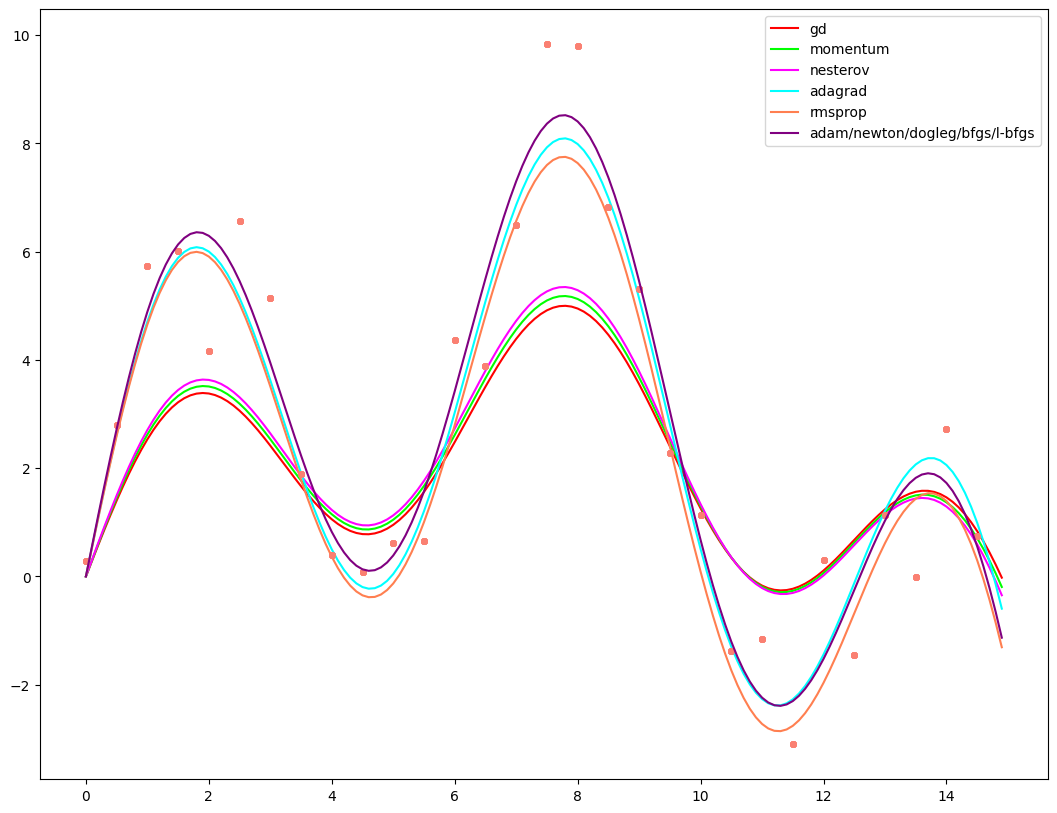

initial: [-2, -2, -2, -2]
current_cost: 1396.30315150541, epoch: 499     gd
current_cost: 370.360425348192, epoch: 499     momentum
current_cost: 1621.93839680821, epoch: 499     nesterov
current_cost: 32.0426327476542, epoch: 499     adagrad
current_cost: 49.0305203414599, epoch: 499     rmsprop
current_cost: 29.5595351496403, epoch: 374     adam
current_cost: 29.5595250969892, epoch: 2     newton
current_cost: 29.5595250969892, epoch: 5     dogleg
current_cost: 29.5595250969930, epoch: 16     bfgs
current_cost: 29.5595250976559, epoch: 34     l-bfgs    m=10
current_cost: 29.5595250969895, epoch: 33     l-bfgs    m=100
current_cost: 29.5595250969895, epoch: 33     l-bfgs    m=40
current_cost: 29.5595469711735, epoch: 231     l-bfgs    m=2


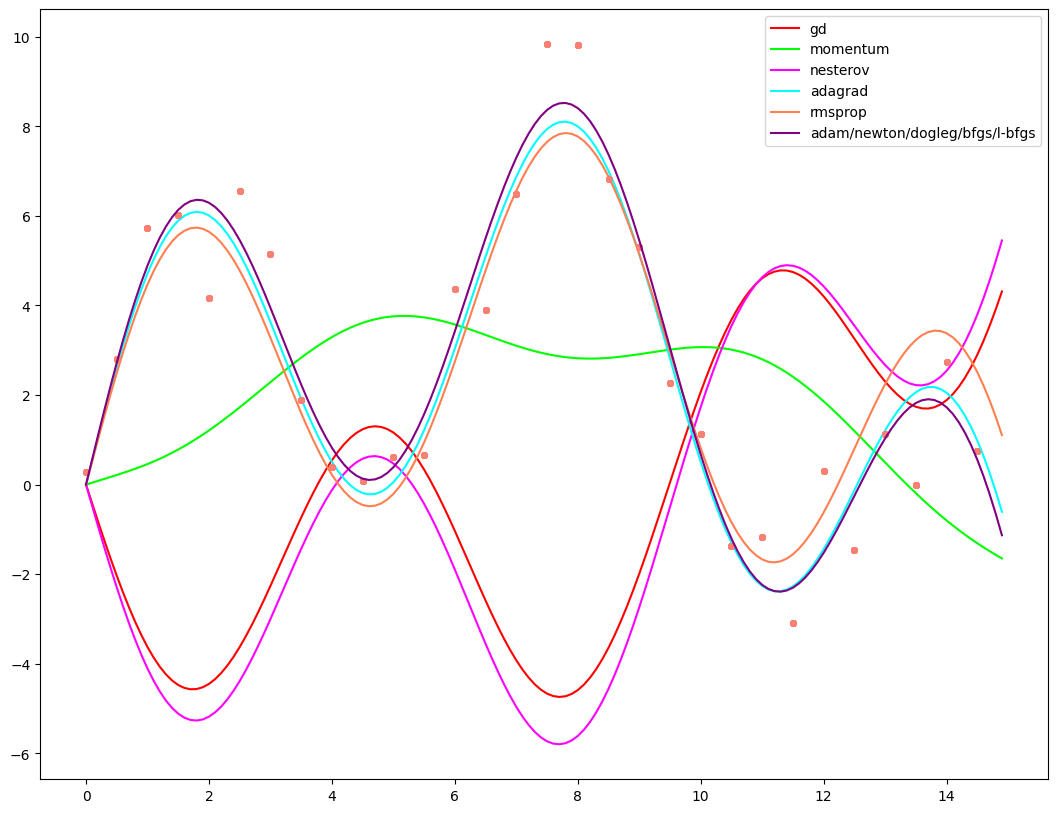

In [19]:
TOTAL = 30
STEP = 0.5
FROM = 0
INITIAL_THETA = [1] * 4
lr = 1
eps = 1e-6

def mysin(x):
    return sp.sin(x)

def mysqrt(x):
    return sp.sin(x)

X_new = np.arange(0, 15, 0.1, dtype=np.float64)


symbols = sp.symbols(f"x:{len(INITIAL_THETA)}")
x = sp.symbols("x")
y = sp.symbols("y")

def function1(x):
  return 4 * sp.sin(x) + x ** 0.5 - 0.1 * x ** 2 + 1 * x

func1 = symbols[0] * sp.sin(x) + symbols[1] * sp.sqrt(x) + symbols[2] * x ** 2 + symbols[3] * x 


func = sp.lambdify([symbols, x], func1, {"sin":mysin, "sqrt":mysqrt})

loss_func = (y - func(symbols, x)) ** 2
loss_function_grad = [sp.diff(loss_func, symbol) for symbol in symbols]
loss_function_grad = [sp.lambdify([symbols, y, x], grad, 'numpy') for grad in loss_function_grad]

hessian = [[sp.diff(sp.diff(loss_func, a), b) for a in symbols] for b in symbols]
hessian_func = [[i for i in range(len(hessian))] for _ in range(len(hessian[0]))]
for i in range(len(hessian)):
  for j in range(len(hessian[i])):
    hessian_func[i][j] = sp.lambdify([symbols, y, x], hessian[i][j], 'numpy')

X = np.arange(FROM, TOTAL * STEP + FROM, STEP, dtype=np.float64)
Y = np.array([function1(x1) + np.random.uniform(-1, 1) * np.random.uniform(1, 3) for x1 in X], dtype=np.float64)

print("initial:", INITIAL_THETA)
result = [0 for i in range(10)]

# ITER = 1
# frame1 = format_dataframe([
#    lambda: profile(lambda: gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-7, eps=eps), "gradient_descent(theta=1)", "fun1"),
#    lambda: profile(lambda: gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-6, eps=eps), "gradient_descent_momentum(theta=1)", "fun1"),
#    lambda: profile(lambda: gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-6, eps=eps), "gradient_descent_nesterov(theta=1)", "fun1"),
#    lambda: profile(lambda: gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=100, eps=eps), "gradient_descent_adagrad(theta=1)", "fun1"),
#    lambda: profile(lambda: gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=0.007, eps=eps), "gradient_descent_rmsprop(theta=1)", "fun1"),
#    lambda: profile(lambda: gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1, eps=eps), "gradient_descent_adam(theta=1)", "fun1"),
#    lambda: profile(lambda: gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps), "gauss_newton(theta=1)", "fun1"),
#    lambda: profile(lambda: powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps), "powell_dog_leg(theta=1)", "fun1"),
#    lambda: profile(lambda: bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps), "bfgs(theta=1)", "fun1"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=5), "lbfgs m=5(theta=1)", "fun1"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=100), "lbfgs m=100(theta=1)", "fun1"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=40), "lbfgs m=40(theta=1)", "fun1"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=2), "lbfgs m=2(theta=1)", "fun1")
# ], ITER)


result[0] = gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-7, eps=eps)
result[1] = gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-6, eps=eps)
result[2] = gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-6, eps=eps)
result[3] = gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=100, eps=eps)
result[4] = gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=0.007, eps=eps)
gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1, eps=eps)

result[5] = gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps)
powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps)
bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=5)

# сделай таблички с разыными m
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=100)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=40)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=2)

colors = ['red', 'lime', 'fuchsia', 'aqua', 'coral', 'purple']
labels = ['gd', 'momentum', 'nesterov', 'adagrad', 'rmsprop', 'adam/newton/dogleg/bfgs/l-bfgs']

plt.rcParams["figure.figsize"] = (13, 10)
fig, ax = plt.subplots()

for i in range(len(labels)):
  ax.plot(X, Y, 'o', color='salmon', zorder=4, markersize=4)
  ax.plot(X_new, [func(result[i], p) for p in X_new], '-', color=colors[i], zorder=4, markersize=4, label=labels[i])
ax.legend()
plt.show()

# мне впадлу это как то обобщать, честно (там разные lr если че)

INITIAL_THETA = [-2] * 4

print("initial:", INITIAL_THETA)

# frame2 = format_dataframe([
#    lambda: profile(lambda: gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=3e-6, eps=eps), "gradient_descent(theta=-2)", "fun1"),
#    lambda: profile(lambda: gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2e-5, eps=eps), "gradient_descent_momentum(theta=-2)", "fun1"),
#    lambda: profile(lambda: gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-6, eps=eps), "gradient_descent_nesterov(theta=-2)", "fun1"),
#    lambda: profile(lambda: gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=100, eps=eps), "gradient_descent_adagrad(theta=-2)", "fun1"),
#    lambda: profile(lambda: gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=0.009, eps=eps), "gradient_descent_rmsprop(theta=-2)", "fun1"),
#    lambda: profile(lambda: gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1, eps=eps), "gradient_descent_adam(theta=-2)", "fun1"),
#    lambda: profile(lambda: gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps), "gauss_newton(theta=-2)", "fun1"),
#    lambda: profile(lambda: powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps), "powell_dog_leg(theta=-2)", "fun1"),
#    lambda: profile(lambda: bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps), "bfgs(theta=-2)", "fun1"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps), "lbfgs m=10(theta=-2)", "fun1"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=100), "lbfgs m=100(theta=-2)", "fun1"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=40), "lbfgs m=40(theta=-2)", "fun1"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=2), "lbfgs m=2(theta=-2)", "fun1")
# ], ITER)


result = [0 for i in range(10)]

result[0] = gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=3e-6, eps=eps)
result[1] = gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2e-5, eps=eps)
result[2] = gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-6, eps=eps)
result[3] = gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=100, eps=eps)
result[4] = gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=0.009, eps=eps)
gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1, eps=eps)

result[5] = gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps)
powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps)
bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps)

lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=100)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=40)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=2)

fig, ax = plt.subplots()

for i in range(len(labels)):
  ax.plot(X, Y, 'o', color='salmon', zorder=4, markersize=4)
  ax.plot(X_new, [func(result[i], p) for p in X_new], '-', color=colors[i], zorder=4, markersize=4, label=labels[i])
ax.legend()
plt.show()

In [20]:
# theta = 1 avg of 30
# frame1

,Cost function (less is better),Iterations,Time (sec),Memory (KiB)
gradient_descent,174.652671590789,500.0,31.652600,2687.930143
gradient_descent_momentum,160.284923713369,500.0,31.783400,2627.829688
gradient_descent_nesterov,148.139109826128,500.0,31.621000,2646.095508
gradient_descent_adagrad,37.6890203542765,500.0,31.539600,2650.850456
gradient_descent_rmsprop,44.6522490827888,500.0,31.396733,2633.098177
gradient_descent_adam,34.4052546082169,225.0,14.129267,2734.174740
gauss_newton,34.4052383441525,3.0,0.430400,516.906250
powell_dog_leg,34.4052383441524,4.0,0.349600,382.856510
bfgs,34.4052383441636,16.0,4.775600,2630.140560
lbfgs m=5,34.4052433419379,36.0,6.241333,2859.590299


In [21]:
# theta = -2 avg of 30
# frame2

,Cost function (less is better),Iterations,Time (sec),Memory (KiB)
gradient_descent,1519.29146669150,500.0,31.572467,2671.364128
gradient_descent_momentum,398.616786519609,500.0,31.729600,2689.282747
gradient_descent_nesterov,1769.08226666435,500.0,31.664200,2636.789453
gradient_descent_adagrad,37.5334317912340,500.0,31.598533,2653.771029
gradient_descent_rmsprop,60.3243169849952,500.0,31.793867,2614.678125
gradient_descent_adam,34.4052482584514,378.0,23.941800,2733.040951
gauss_newton,34.4052383441524,3.0,0.434200,492.715234
powell_dog_leg,34.4052383441524,7.0,0.677133,707.717773
bfgs,34.4052383441572,17.0,4.858000,2626.376107
lbfgs m=10,34.4052383642617,34.0,6.073600,2844.717122


### 2 функция

initial: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
current_cost: 16074.012755478947, epoch: 499     gd
current_cost: 16089.512755878703, epoch: 499     momentum
current_cost: 15328.196844381731, epoch: 499     nesterov
current_cost: 1067.170218141365, epoch: 499     adagrad
current_cost: 6211.505022222898, epoch: 499     rmsprop
current_cost: 983.6104441153446, epoch: 499     adam
current_cost: 41.95803186774667, epoch: 2     newton
current_cost: 41.95803186774602, epoch: 7     dogleg
current_cost: 41.958031867749106, epoch: 38     bfgs
current_cost: 467.600293819642, epoch: 176     l-bfgs    m=5
current_cost: 467.60132719128217, epoch: 76     l-bfgs    m=100
current_cost: 467.6013271856464, epoch: 76     l-bfgs    m=40
current_cost: 978.7836816037776, epoch: 214     l-bfgs    m=2


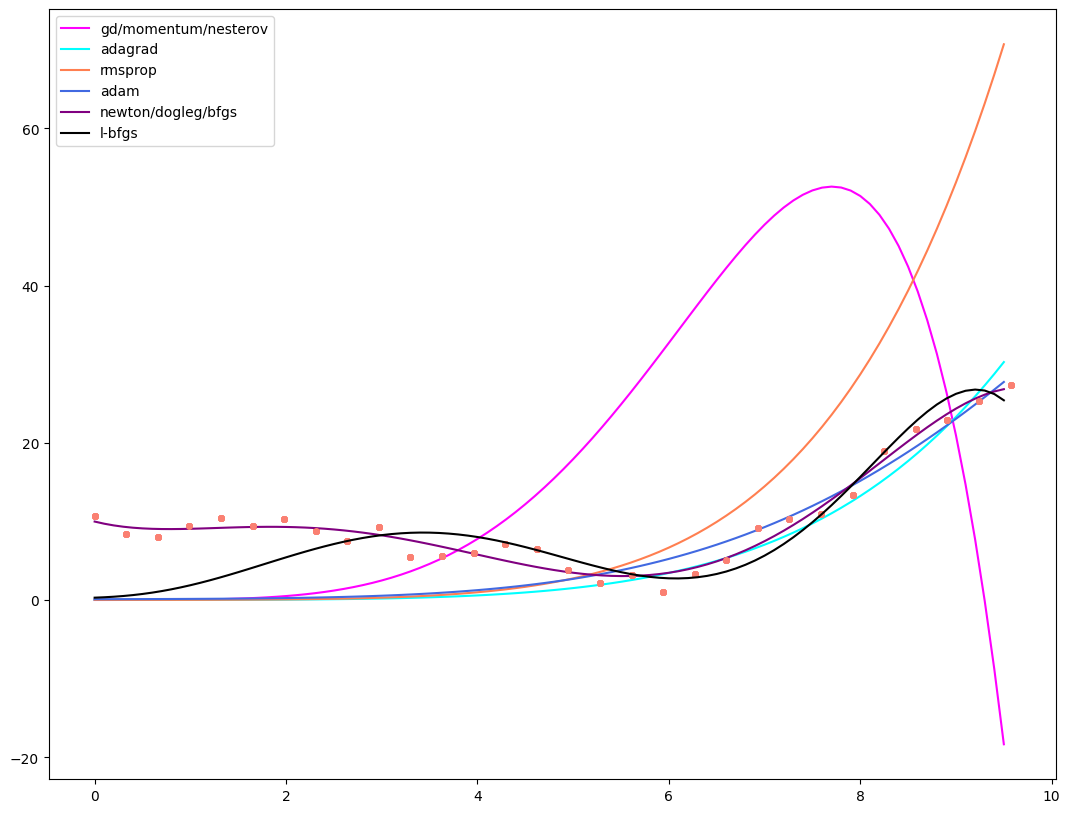

initial: [-0.002, -0.002, -0.002, -0.002, -0.002, -0.002, -0.002]
current_cost: 2580.2996027284453, epoch: 499     gd
current_cost: 2581.8762583683683, epoch: 499     momentum
current_cost: 2504.422641237753, epoch: 499     nesterov
current_cost: 1067.1751958520472, epoch: 499     adagrad
current_cost: 6199.598804285931, epoch: 499     rmsprop
current_cost: 983.9208573013353, epoch: 499     adam
current_cost: 41.95803186774615, epoch: 2     newton
current_cost: 41.95803186774622, epoch: 5     dogleg
current_cost: 41.958031868439335, epoch: 37     bfgs
current_cost: 993.5091370808611, epoch: 69     l-bfgs    m=5
current_cost: 469.1696559841279, epoch: 69     l-bfgs    m=100
current_cost: 469.1696570919085, epoch: 70     l-bfgs    m=40
current_cost: 994.7352832919048, epoch: 167     l-bfgs    m=2


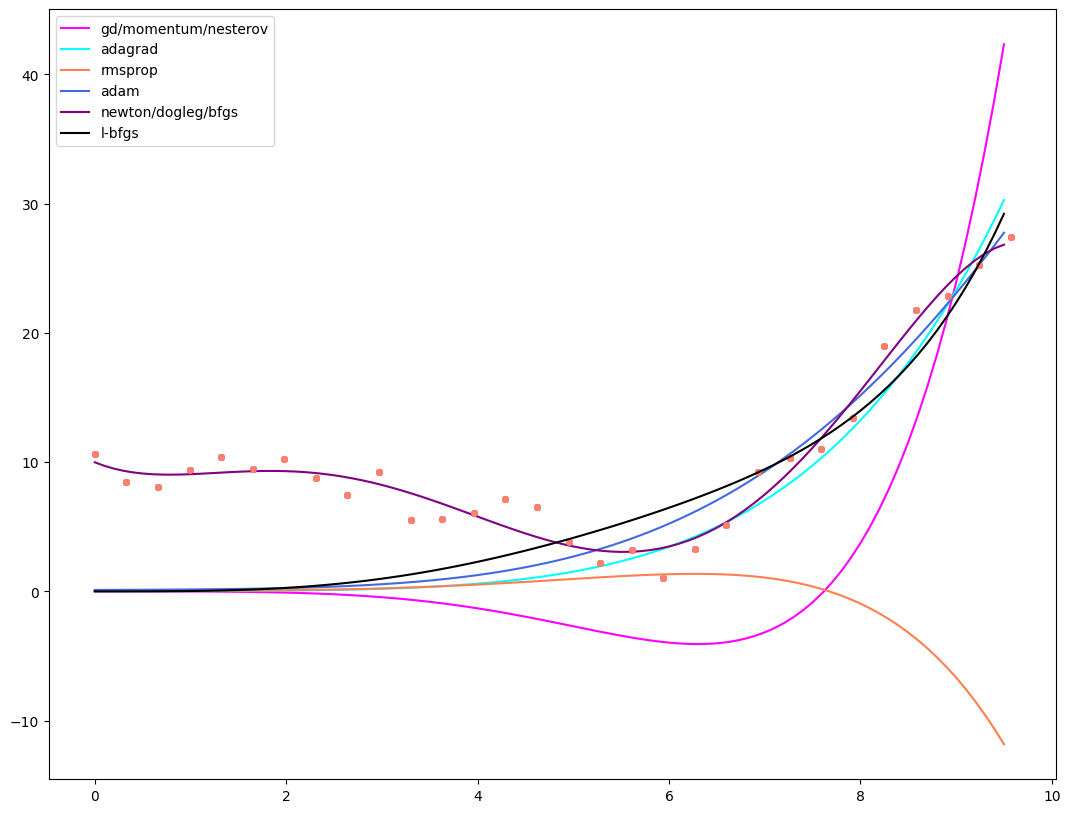

In [23]:
TOTAL = 30
STEP = 0.33
FROM = 0
INITIAL_THETA = [0.01] * 7
lr = 1
eps = 1e-6

def mysin(x):
    return sp.sin(x)

def mysqrt(x):
    return sp.sin(x)

X_new = np.arange(0, 9.6, 0.1, dtype=np.float64)


symbols = sp.symbols(f"x:{len(INITIAL_THETA)}")
x = sp.symbols("x")
y = sp.symbols("y")

def function1(x):
  return 8 + x + 1 * x ** 2 -0.7 * x ** 3 + 0.1 * x ** 4 - 0.002 * x ** 5 - 0.00019 * x ** 6

func1 = symbols[0] + symbols[1] * x + symbols[2] * x ** 2 + symbols[3] * x ** 3 + symbols[4] * x ** 4 + symbols[5] * x ** 5 + symbols[6] * x ** 6


func = sp.lambdify([symbols, x], func1, 'numpy')

loss_func = (y - func(symbols, x)) ** 2
loss_function_grad = [sp.diff(loss_func, symbol) for symbol in symbols]
loss_function_grad = [sp.lambdify([symbols, y, x], grad, 'numpy') for grad in loss_function_grad]

hessian = [[sp.diff(sp.diff(loss_func, a), b) for a in symbols] for b in symbols]
hessian_func = [[i for i in range(len(hessian))] for _ in range(len(hessian[0]))]
for i in range(len(hessian)):
  for j in range(len(hessian[i])):
    hessian_func[i][j] = sp.lambdify([symbols, y, x], hessian[i][j], 'numpy')

X = np.arange(FROM, TOTAL * STEP + FROM, STEP, dtype=np.float64)
Y = np.array([function1(x1) + np.random.uniform(-1, 1) * np.random.uniform(1, 3) for x1 in X], dtype=np.float64)

print("initial:", INITIAL_THETA)
result = [0 for i in range(10)]

# ITER = 1
# frame3 = format_dataframe([
#    lambda: profile(lambda: gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2e-13, eps=eps), "gradient_descent(theta=0.01)", "fun2"),
#    lambda: profile(lambda: gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2e-13, eps=eps), "gradient_descent_momentum(theta=0.01)", "fun2"),
#    lambda: profile(lambda: gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2e-13, eps=eps), "gradient_descent_nesterov(theta=0.01)", "fun2"),
#    lambda: profile(lambda: gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=100, eps=eps), "gradient_descent_adagrad(theta=0.01)", "fun2"),
#    lambda: profile(lambda: gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=0.0001, eps=eps), "gradient_descent_rmsprop(theta=0.01)", "fun2"),
#    lambda: profile(lambda: gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1, eps=eps), "gradient_descent_adam(theta=0.01)", "fun2"),
#    lambda: profile(lambda: gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps), "gauss_newton(theta=0.01)", "fun2"),
#    lambda: profile(lambda: powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps), "powell_dog_leg(theta=0.01)", "fun2"),
#    lambda: profile(lambda: bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps), "bfgs(theta=0.01)", "fun2"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=5), "lbfgs m=5(theta=0.01)", "fun2"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=100), "lbfgs m=100(theta=0.01)", "fun2"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=40), "lbfgs m=40(theta=0.01)", "fun2"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=2), "lbfgs m=2(theta=0.01)", "fun2")
# ], ITER)

result[0] = gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2e-13, eps=eps)
gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2e-13, eps=eps)
gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2e-13, eps=eps)
result[1] = gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=100, eps=eps)
result[2] = gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=0.0001, eps=eps)
result[3] = gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1, eps=eps)

result[4] = gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps)
powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps)
bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps)
result[5] = lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=5)

# сделай таблички с разыными m
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=100)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=40)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=2)

colors = ['fuchsia', 'aqua', 'coral', 'royalblue', 'purple', 'black']
labels = ['gd/momentum/nesterov', 'adagrad', 'rmsprop', 'adam', 'newton/dogleg/bfgs', 'l-bfgs']

plt.rcParams["figure.figsize"] = (13, 10)
fig, ax = plt.subplots()

for i in range(len(labels)):
  ax.plot(X, Y, 'o', color='salmon', zorder=4, markersize=4)
  ax.plot(X_new, [func(result[i], p) for p in X_new], '-', color=colors[i], zorder=4, markersize=4, label=labels[i])
ax.legend()
plt.show()

INITIAL_THETA = [-0.002] * 7

print("initial:", INITIAL_THETA)

# ITER = 1
# frame4 = format_dataframe([
#    lambda: profile(lambda: gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2e-13, eps=eps), "gradient_descent(theta=-0.002)", "fun2"),
#    lambda: profile(lambda: gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2e-13, eps=eps), "gradient_descent_momentum(theta=-0.002)", "fun2"),
#    lambda: profile(lambda: gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2e-13, eps=eps), "gradient_descent_nesterov(theta=-0.002)", "fun2"),
#    lambda: profile(lambda: gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=100, eps=eps), "gradient_descent_adagrad(theta=-0.002)", "fun2"),
#    lambda: profile(lambda: gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=0.0001, eps=eps), "gradient_descent_rmsprop(theta=-0.002)", "fun2"),
#    lambda: profile(lambda: gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1, eps=eps), "gradient_descent_adam(theta=-0.002)", "fun2"),
#    lambda: profile(lambda: gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps), "gauss_newton(theta=-0.002)", "fun2"),
#    lambda: profile(lambda: powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps), "powell_dog_leg(theta=-0.002)", "fun2"),
#    lambda: profile(lambda: bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps), "bfgs(theta=-0.002)", "fun2"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=5), "lbfgs m=5(theta=-0.002)", "fun2"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=100), "lbfgs m=100(theta=-0.002)", "fun2"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=40), "lbfgs m=40(theta=-0.002)", "fun2"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=2), "lbfgs m=2(theta=-0.002)", "fun2")
# ], ITER)

result = [0 for i in range(10)]

result[0] = gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2e-13, eps=eps)
gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2e-13, eps=eps)
gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2e-13, eps=eps)
result[1] = gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=100, eps=eps)
result[2] = gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=0.0001, eps=eps)
result[3] = gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1, eps=eps)

result[4] = gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps)
powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps)
bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps)
result[5] = lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=5)

# если поменять m, то l-bfgs заебись становится 
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=100)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=40)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=2)

fig, ax = plt.subplots()

for i in range(len(labels)):
  ax.plot(X, Y, 'o', color='salmon', zorder=4, markersize=4)
  ax.plot(X_new, [func(result[i], p) for p in X_new], '-', color=colors[i], zorder=4, markersize=4, label=labels[i])
ax.legend()
plt.show()

In [24]:
# theta = 0.1 avg og 30
# frame3

,Cost function (less is better),Iterations,Time (sec),Memory (KiB)
gradient_descent,15526.962922,500.0,1.945,8.082031
gradient_descent_momentum,15541.984040,500.0,1.952,4.879883
gradient_descent_nesterov,14804.196047,500.0,1.991,4.873047
gradient_descent_adagrad,1010.518229,500.0,2.048,4.880859
gradient_descent_rmsprop,6146.562241,500.0,2.079,4.879883
gradient_descent_adam,907.266884,500.0,2.042,5.260742
gauss_newton,48.479309,3.0,0.010,13.970703
powell_dog_leg,48.479309,8.0,0.131,44.251953
bfgs,48.479309,40.0,8.703,2391.962891
lbfgs m=5,888.706041,68.0,8.920,1714.464844


In [25]:
# theta = -0.002 avg of 30
# frame4

,Cost function (less is better),Iterations,Time (sec),Memory (KiB)
gradient_descent,2665.631937,500.0,1.964,4.078125
gradient_descent_momentum,2667.366297,500.0,1.962,4.484375
gradient_descent_nesterov,2582.164532,500.0,1.972,4.433594
gradient_descent_adagrad,1010.524842,500.0,1.992,4.935547
gradient_descent_rmsprop,6130.711006,500.0,1.976,4.986328
gradient_descent_adam,907.587303,500.0,1.990,5.425781
gauss_newton,48.479309,3.0,0.009,13.970703
powell_dog_leg,48.479309,6.0,0.093,19.720703
bfgs,48.479309,39.0,8.091,1702.226562
lbfgs m=5,902.756219,58.0,8.724,1691.672852


### 3 функция (забей хуй на нее, не будем ее вставлять) (ОК)

In [ ]:
TOTAL = 30
STEP = 0.5
FROM = 0
INITIAL_THETA = [1.1, -0.1, 0.003]
lr = 1
eps = 1e-6

def mysin(x):
    return sp.sin(x)

def mysqrt(x):
    return sp.sin(x)

X_new = np.arange(0, 15, 0.1, dtype=np.float64)


symbols = sp.symbols(f"x:{len(INITIAL_THETA)}")
x = sp.symbols("x")
y = sp.symbols("y")

def function1(x):
  return 3 ** (x - 0.1 * x ** 2 + 0.003 * x ** 3)

func1 = 3 ** (symbols[0] * x + symbols[1] * x ** 2 + symbols[2] * x ** 3)


func = sp.lambdify([symbols, x], func1, 'numpy')

loss_func = (y - func(symbols, x)) ** 2
loss_function_grad = [sp.diff(loss_func, symbol) for symbol in symbols]
loss_function_grad = [sp.lambdify([symbols, y, x], grad, 'numpy') for grad in loss_function_grad]

hessian = [[sp.diff(sp.diff(loss_func, a), b) for a in symbols] for b in symbols]
hessian_func = [[i for i in range(len(hessian))] for _ in range(len(hessian[0]))]
for i in range(len(hessian)):
  for j in range(len(hessian[i])):
    hessian_func[i][j] = sp.lambdify([symbols, y, x], hessian[i][j], 'numpy')

X = np.arange(FROM, TOTAL * STEP + FROM, STEP, dtype=np.float64)
Y = np.array([function1(x1) for x1 in X], dtype=np.float64)

print("initial:", INITIAL_THETA)
result = [0 for i in range(10)]

result[0] = gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-13, eps=eps)
result[1] = gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-13, eps=eps)
result[2] = gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-13, eps=eps)
result[3] = gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-6, eps=eps)
result[4] = gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-2, eps=eps)
result[5] = gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-4, eps=eps)

result[6] = gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps)
result[7] = powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps)
result[8] = bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps)
result[9] = lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=5)

# бля я хз оставлять ли это, выглядит пиздато, но ошибки в l-bfgs мне не нравятся))))))))))) 
# да поебать мне кажется, в отчет че нибудь придумаем по цифорам
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=100)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=40)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=2)

colors = ['red', 'lime', 'fuchsia', 'aqua', 'coral', 'royalblue', 'purple']
labels = ['gd', 'momentum', 'nesterov', 'adagrad', 'rmsprop', 'adam', 'new_methods']

plt.rcParams["figure.figsize"] = (20, 15)
fig, ax = plt.subplots()

for i in range(len(labels)):
  ax.plot(X, Y, 'o', color='salmon', zorder=4, markersize=4)
  ax.plot(X_new, [func(result[i], p) for p in X_new], '-', color=colors[i], zorder=4, markersize=4, label=labels[i])
ax.legend()
plt.show()

### 4 функция

initial: [0, 0, 0, 0]
current_cost: 1150.41238612428, epoch: 499     gd
current_cost: 1154.49910073261, epoch: 499     momentum
current_cost: 947.835760310639, epoch: 499     nesterov
current_cost: 183.071368965478, epoch: 499     adagrad
current_cost: 214.168213462760, epoch: 499     rmsprop
current_cost: 21.9287040987775, epoch: 499     adam
current_cost: 21.1944499990912, epoch: 2     newton
current_cost: 21.1944499990911, epoch: 6     dogleg
current_cost: 21.1944499994628, epoch: 18     bfgs
current_cost: 21.1944591126369, epoch: 101     l-bfgs    m=5
current_cost: 21.1944499991316, epoch: 40     l-bfgs    m=100
current_cost: 21.1944499991316, epoch: 40     l-bfgs    m=40
current_cost: 22.0003110182525, epoch: 499     l-bfgs    m=2


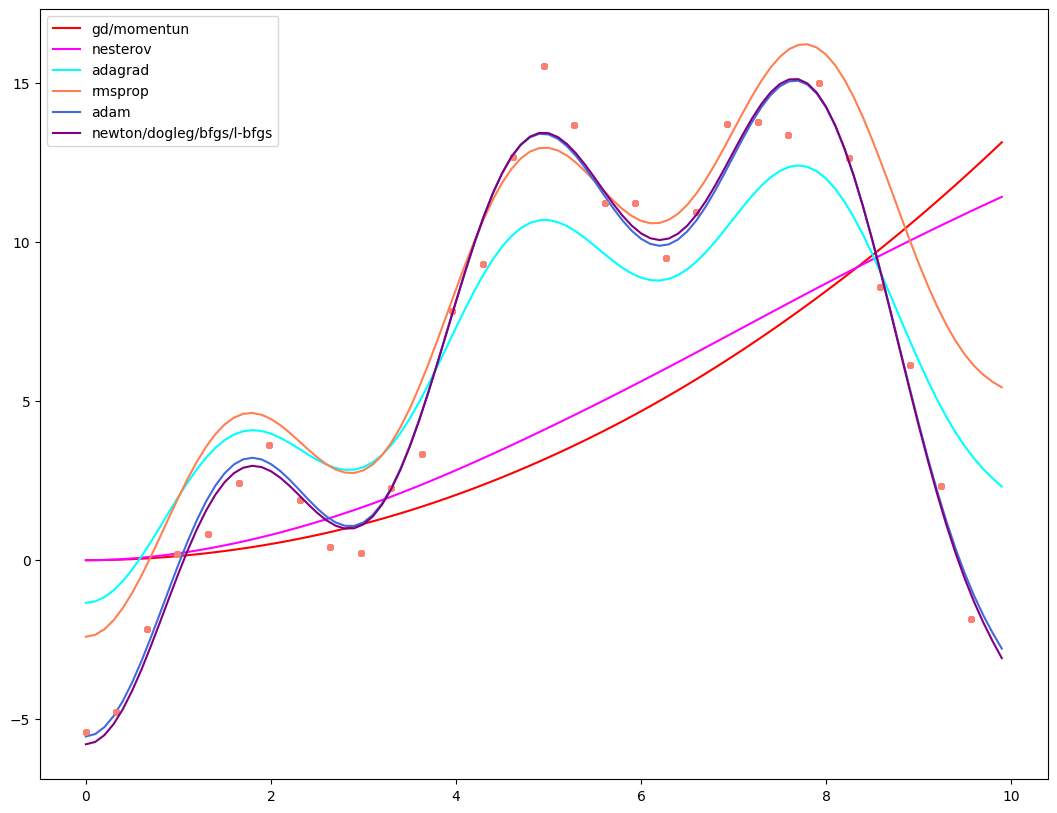

initial: [-1, 0, 1, -1]
current_cost: 4036.20358672001, epoch: 499     gd
current_cost: 4053.66978927599, epoch: 499     momentum
current_cost: 3170.37782650834, epoch: 499     nesterov
current_cost: 477.168894686423, epoch: 499     adagrad
current_cost: 315.899910590591, epoch: 499     rmsprop
current_cost: 33.8417292584717, epoch: 499     adam
current_cost: 21.1944499990911, epoch: 2     newton
current_cost: 21.1944499990911, epoch: 5     dogleg
current_cost: 21.1944499992397, epoch: 20     bfgs
current_cost: 21.1944517454004, epoch: 97     l-bfgs    m=5
current_cost: 21.1944500019165, epoch: 38     l-bfgs    m=100
current_cost: 21.1944500019165, epoch: 38     l-bfgs    m=40
current_cost: 21.4475142171575, epoch: 499     l-bfgs    m=2


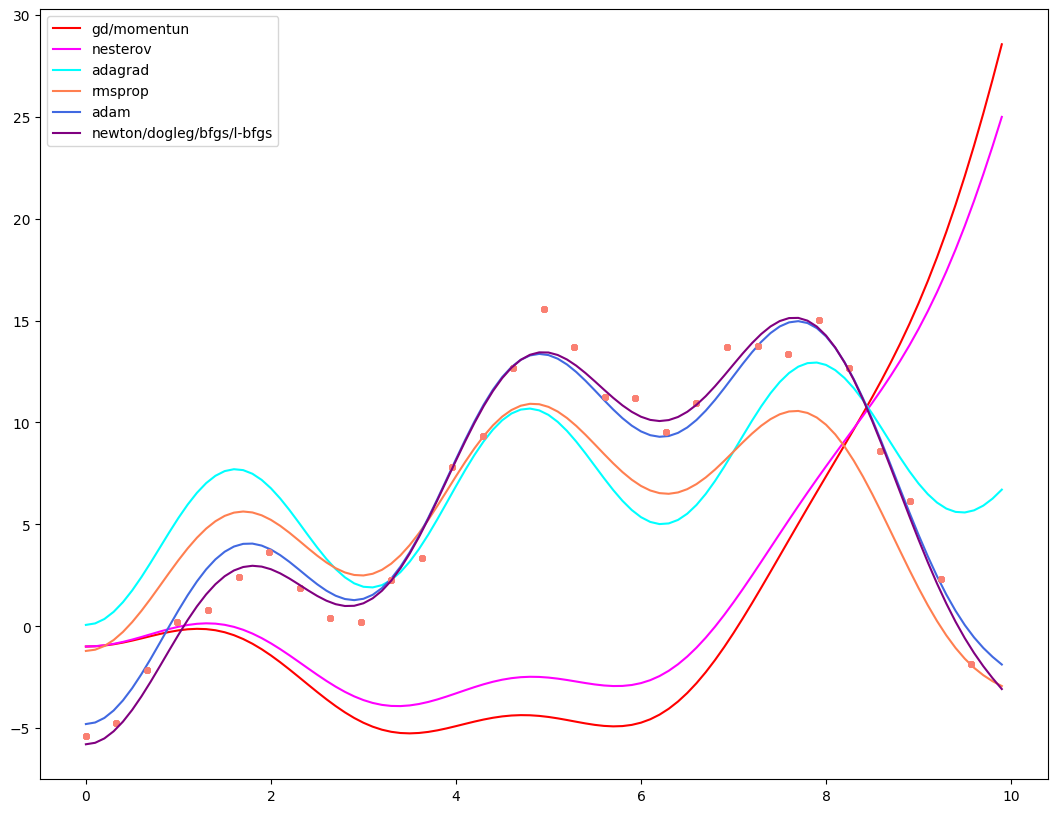

In [26]:
TOTAL = 30
STEP = 0.33
FROM = 0
INITIAL_THETA = [0] * 4
lr = 1
eps = 1e-6

def mysin(x):
    return sp.sin(x)

def mycos(x):
    return sp.cos(x)

X_new = np.arange(0, 10, 0.1, dtype=np.float64)


symbols = sp.symbols(f"x:{len(INITIAL_THETA)}")
x = sp.symbols("x")
y = sp.symbols("y")

def function1(x):
  return x ** 2 - 0.1 * x ** 3 + sp.sin(x) ** 2 - 5 * sp.cos(x) ** 2

func1 = symbols[0] * x ** 2 + symbols[1] * x ** 3 + symbols[2] * sp.sin(x) ** 2 + symbols[3] * sp.cos(x) ** 2


func = sp.lambdify([symbols, x], func1, {"sin":mysin, "cos":mycos})

loss_func = (y - func(symbols, x)) ** 2
loss_function_grad = [sp.diff(loss_func, symbol) for symbol in symbols]
loss_function_grad = [sp.lambdify([symbols, y, x], grad, 'numpy') for grad in loss_function_grad]

hessian = [[sp.diff(sp.diff(loss_func, a), b) for a in symbols] for b in symbols]
hessian_func = [[i for i in range(len(hessian))] for _ in range(len(hessian[0]))]
for i in range(len(hessian)):
  for j in range(len(hessian[i])):
    hessian_func[i][j] = sp.lambdify([symbols, y, x], hessian[i][j], 'numpy')

X = np.arange(FROM, TOTAL * STEP + FROM, STEP, dtype=np.float64)
Y = np.array([function1(x1) + np.random.uniform(-1, 1) * np.random.uniform(1, 3) for x1 in X], dtype=np.float64)

print("initial:", INITIAL_THETA)
result = [0 for i in range(10)]

# ITER = 1
# frame5 = format_dataframe([
#    lambda: profile(lambda: gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-7, eps=eps), "gradient_descent(theta=0)", "fun4"),
#    lambda: profile(lambda: gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-7, eps=eps), "gradient_descent_momentum(theta=0)", "fun4"),
#    lambda: profile(lambda: gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-7, eps=eps), "gradient_descent_nesterov(theta=0)", "fun4"),
#    lambda: profile(lambda: gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-1, eps=eps), "gradient_descent_adagrad(theta=0)", "fun4"),
#    lambda: profile(lambda: gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-2, eps=eps), "gradient_descent_rmsprop(theta=0)", "fun4"),
#    lambda: profile(lambda: gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-1, eps=eps), "gradient_descent_adam(theta=0)", "fun4"),
#    lambda: profile(lambda: gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps), "gauss_newton(theta=0)", "fun4"),
#    lambda: profile(lambda: powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps), "powell_dog_leg(theta=0)", "fun4"),
#    lambda: profile(lambda: bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps), "bfgs(theta=0)", "fun4"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=5), "lbfgs m=5(theta=0)", "fun4"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=100), "lbfgs m=100(theta=0)", "fun4"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=40), "lbfgs m=40(theta=0)", "fun4"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=2), "lbfgs m=2(theta=0)", "fun4")
# ], ITER)

result[0] = gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-7, eps=eps)
gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-7, eps=eps)
result[1] = gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-7, eps=eps)
result[2] = gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-1, eps=eps)
result[3] = gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-2, eps=eps)
result[4] = gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-1, eps=eps)

result[5] = gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps)
powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps)
bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=5)

lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=100)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=40)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=2)

colors = ['red', 'fuchsia', 'aqua', 'coral', 'royalblue', 'purple']
labels = ['gd/momentun', 'nesterov', 'adagrad', 'rmsprop', 'adam', 'newton/dogleg/bfgs/l-bfgs']

plt.rcParams["figure.figsize"] = (13, 10)
fig, ax = plt.subplots()

for i in range(len(labels)):
  ax.plot(X, Y, 'o', color='salmon', zorder=4, markersize=4)
  ax.plot(X_new, [func(result[i], p) for p in X_new], '-', color=colors[i], zorder=4, markersize=4, label=labels[i])
ax.legend()
plt.show()

INITIAL_THETA = [-1, 0, 1, -1]

print("initial:", INITIAL_THETA)
result = [0 for i in range(10)]

# ITER = 1
# frame6 = format_dataframe([
#    lambda: profile(lambda: gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-7, eps=eps), "gradient_descent(theta=-1)", "fun4"),
#    lambda: profile(lambda: gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-7, eps=eps), "gradient_descent_momentum(theta=-1)", "fun4"),
#    lambda: profile(lambda: gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-7, eps=eps), "gradient_descent_nesterov(theta=-1)", "fun4"),
#    lambda: profile(lambda: gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2, eps=eps), "gradient_descent_adagrad(theta=-1)", "fun4"),
#    lambda: profile(lambda: gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-2, eps=eps), "gradient_descent_rmsprop(theta=-1)", "fun4"),
#    lambda: profile(lambda: gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-1, eps=eps), "gradient_descent_adam(theta=-1)", "fun4"),
#    lambda: profile(lambda: gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps), "gauss_newton(theta=-1)", "fun4"),
#    lambda: profile(lambda: powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps), "powell_dog_leg(theta=-1)", "fun4"),
#    lambda: profile(lambda: bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps), "bfgs(theta=-1)", "fun4"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=5), "lbfgs m=5(theta=-1)", "fun4"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=100), "lbfgs m=100(theta=-1)", "fun4"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=40), "lbfgs m=40(theta=-1)", "fun4"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=2), "lbfgs m=2(theta=-1)", "fun4")
# ], ITER)

result[0] = gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-7, eps=eps)
gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-7, eps=eps)
result[1] = gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-7, eps=eps)
result[2] = gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2, eps=eps)
result[3] = gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-2, eps=eps)
result[4] = gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-1, eps=eps)

result[5] = gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps)
powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps)
bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=5)

lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=100)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=40)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=2)

fig, ax = plt.subplots()

for i in range(len(labels)):
  ax.plot(X, Y, 'o', color='salmon', zorder=4, markersize=4)
  ax.plot(X_new, [func(result[i], p) for p in X_new], '-', color=colors[i], zorder=4, markersize=4, label=labels[i])
ax.legend()
plt.show()

In [28]:
# theta = 0 avg of 30
# frame5

,Cost function (less is better),Iterations,Time (sec),Memory (KiB)
gradient_descent,1146.34767655775,500.0,44.370,2585.568359
gradient_descent_momentum,1150.37235654512,500.0,43.839,2520.417969
gradient_descent_nesterov,946.846043348156,500.0,43.754,2519.003906
gradient_descent_adagrad,181.038496824821,500.0,43.937,2597.074219
gradient_descent_rmsprop,218.209890084568,500.0,43.579,2680.133789
gradient_descent_adam,45.0315627748662,500.0,43.959,2627.862305
gauss_newton,44.4932781870008,3.0,0.492,790.399414
powell_dog_leg,44.4932781870008,6.0,0.629,1066.881836
bfgs,44.4932781870135,19.0,5.005,3219.168945
lbfgs m=5,44.4932941688890,111.0,14.687,2915.998047


In [27]:
# theta = [-1....] avg of 30
# frame6

,Cost function (less is better),Iterations,Time (sec),Memory (KiB)
gradient_descent,4013.55651568468,500.0,43.077,2517.800781
gradient_descent_momentum,4030.89418271615,500.0,43.295,2519.186523
gradient_descent_nesterov,3154.10221052416,500.0,43.332,2517.140625
gradient_descent_adagrad,446.857762403827,500.0,43.073,2610.677734
gradient_descent_rmsprop,306.065589321115,500.0,43.050,2660.921875
gradient_descent_adam,55.6406892653842,500.0,43.177,2637.301758
gauss_newton,44.4932781870008,3.0,0.525,925.244141
powell_dog_leg,44.4932781870008,6.0,0.617,928.926758
bfgs,44.4932781878919,21.0,5.059,2758.647461
lbfgs m=5,44.4932783744131,78.0,10.999,2884.746094


### 5 функция

initial: [0, 0, 0, 0, 0, 0, 0]
current_cost: 3198.13443930384, epoch: 499     gd
current_cost: 3198.15365647673, epoch: 499     momentum
current_cost: 3197.21051344855, epoch: 499     nesterov
current_cost: 2107.31038048510, epoch: 499     adagrad
current_cost: 3006.42539865901, epoch: 499     rmsprop
current_cost: 894.170538148036, epoch: 499     adam
current_cost: 33.4531173534590, epoch: 2     newton
current_cost: 33.4531173534590, epoch: 9     dogleg
current_cost: 33.4531173534656, epoch: 26     bfgs
current_cost: 132.125780634780, epoch: 499     l-bfgs    m=5
current_cost: 33.4531173549938, epoch: 76     l-bfgs    m=100
current_cost: 33.4531173564995, epoch: 97     l-bfgs    m=40
current_cost: 1123.59807115216, epoch: 499     l-bfgs    m=2


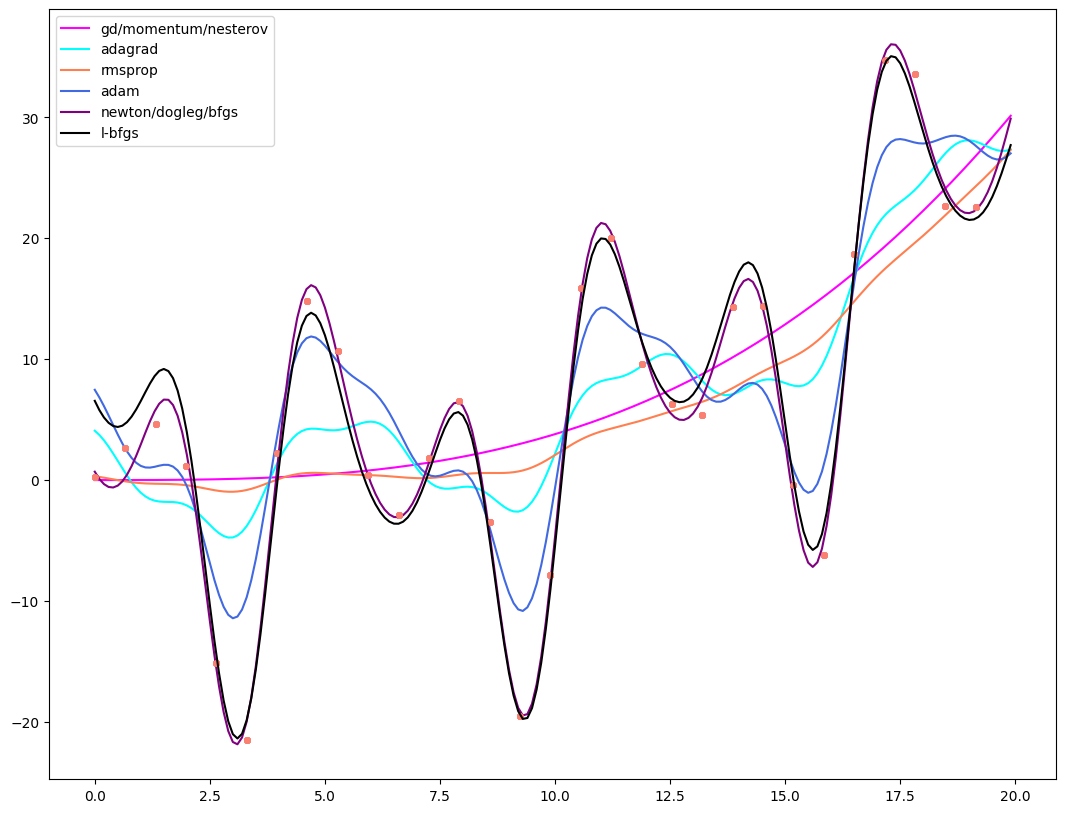

initial: [-100, 0, -100, -10, -100, 0, -100]
current_cost: 462155.741931433, epoch: 499     gd
current_cost: 462281.659988122, epoch: 499     momentum
current_cost: 456101.040949361, epoch: 499     nesterov
current_cost: 134367.700486913, epoch: 499     adagrad
current_cost: 405210.415130040, epoch: 499     rmsprop
current_cost: 48868.4922585270, epoch: 499     adam
current_cost: 33.4531173534590, epoch: 2     newton
current_cost: 33.4531173534590, epoch: 13     dogleg
current_cost: 33.4531173534687, epoch: 27     bfgs
current_cost: 21978.2450910819, epoch: 499     l-bfgs    m=5
current_cost: 33.4531173535768, epoch: 71     l-bfgs    m=100
current_cost: 33.4531174260304, epoch: 86     l-bfgs    m=40
current_cost: 95631.9818452879, epoch: 499     l-bfgs    m=2


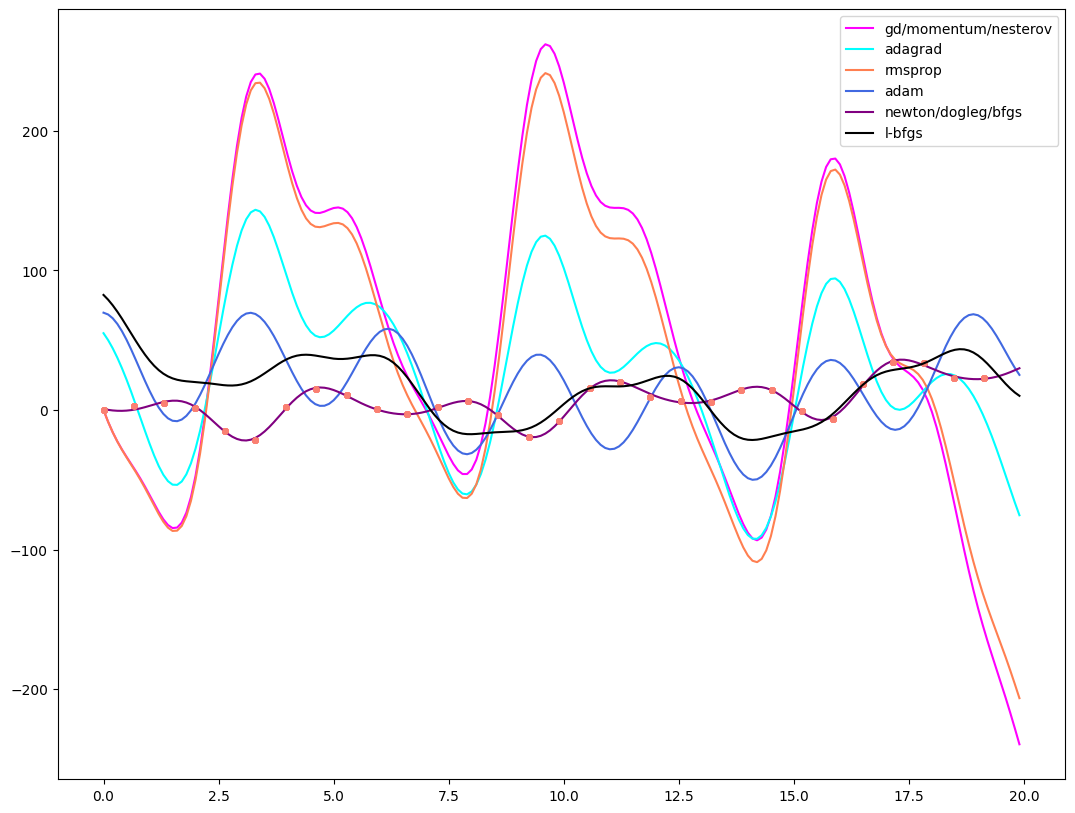

In [29]:
TOTAL = 30
STEP = 0.66
FROM = 0
INITIAL_THETA = [0] * 7
lr = 1
eps = 1e-6

def mysin(x):
    return sp.sin(x)

def mycos(x):
    return sp.cos(x)

X_new = np.arange(0, 20, 0.1, dtype=np.float64)


symbols = sp.symbols(f"x:{len(INITIAL_THETA)}")
x = sp.symbols("x")
y = sp.symbols("y")

def function1(x):
  return -5 * sp.sin(x) + 0.1 * x ** 2 + 10 * sp.cos(x) ** 3 - x - 10 + 0.001 * x ** 3 + 23 * sp.sin(x) ** 2

func1 = symbols[0] * sp.sin(x) + symbols[1] * x ** 2 + symbols[2] * sp.cos(x) ** 3 - symbols[3] * x - symbols[4] + symbols[5] * x ** 3 + symbols[6] * sp.sin(x) ** 2


func = sp.lambdify([symbols, x], func1, {"sin":mysin, "cos":mycos})

loss_func = (y - func(symbols, x)) ** 2
loss_function_grad = [sp.diff(loss_func, symbol) for symbol in symbols]
loss_function_grad = [sp.lambdify([symbols, y, x], grad, 'numpy') for grad in loss_function_grad]

hessian = [[sp.diff(sp.diff(loss_func, a), b) for a in symbols] for b in symbols]
hessian_func = [[i for i in range(len(hessian))] for _ in range(len(hessian[0]))]
for i in range(len(hessian)):
  for j in range(len(hessian[i])):
    hessian_func[i][j] = sp.lambdify([symbols, y, x], hessian[i][j], 'numpy')

X = np.arange(FROM, TOTAL * STEP + FROM, STEP, dtype=np.float64)
Y = np.array([function1(x1) + np.random.uniform(-1, 1) * np.random.uniform(1, 3) for x1 in X], dtype=np.float64)

print("initial:", INITIAL_THETA)
result = [0 for i in range(10)]

# ITER = 1
# frame7 = format_dataframe([
#    lambda: profile(lambda: gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-9, eps=eps), "gradient_descent(theta=0)", "fun5"),
#    lambda: profile(lambda: gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-9, eps=eps), "gradient_descent_momentum(theta=0)", "fun5"),
#    lambda: profile(lambda: gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-9, eps=eps), "gradient_descent_nesterov(theta=0)", "fun5"),
#    lambda: profile(lambda: gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1, eps=eps), "gradient_descent_adagrad(theta=0)", "fun5"),
#    lambda: profile(lambda: gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-3, eps=eps), "gradient_descent_rmsprop(theta=0)", "fun5"),
#    lambda: profile(lambda: gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1, eps=eps), "gradient_descent_adam(theta=0)", "fun5"),
#    lambda: profile(lambda: gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps), "gauss_newton(theta=0)", "fun5"),
#    lambda: profile(lambda: powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps), "powell_dog_leg(theta=0)", "fun5"),
#    lambda: profile(lambda: bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps), "bfgs(theta=0)", "fun5"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=5), "lbfgs m=5(theta=0)", "fun5"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=100), "lbfgs m=100(theta=0)", "fun5"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=40), "lbfgs m=40(theta=0)", "fun5"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=2), "lbfgs m=2(theta=0)", "fun5")
# ], ITER)

result[0] = gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-9, eps=eps)
gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-9, eps=eps)
gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-9, eps=eps)
result[1] = gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1, eps=eps)
result[2] = gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-3, eps=eps)
result[3] = gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1, eps=eps)

result[4] = gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps)
powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps)
bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps)
result[5] = lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=5)

lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=100)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=40)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=2)

colors = ['fuchsia', 'aqua', 'coral', 'royalblue', 'purple', 'black']
labels = ['gd/momentum/nesterov', 'adagrad', 'rmsprop', 'adam', 'newton/dogleg/bfgs', 'l-bfgs']

plt.rcParams["figure.figsize"] = (13, 10)
fig, ax = plt.subplots()

for i in range(len(labels)):
  ax.plot(X, Y, 'o', color='salmon', zorder=4, markersize=4)
  ax.plot(X_new, [func(result[i], p) for p in X_new], '-', color=colors[i], zorder=4, markersize=4, label=labels[i])
ax.legend()
plt.show()

INITIAL_THETA = [-100, 0, -100, -10, -100, 0, -100]

print("initial:", INITIAL_THETA)
result = [0 for i in range(10)]

# ITER = 1
# frame8 = format_dataframe([
#    lambda: profile(lambda: gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-9, eps=eps), "gradient_descent(theta=-100)", "fun5"),
#    lambda: profile(lambda: gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-9, eps=eps), "gradient_descent_momentum(theta=-100)", "fun5"),
#    lambda: profile(lambda: gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-9, eps=eps), "gradient_descent_nesterov(theta=-100)", "fun5"),
#    lambda: profile(lambda: gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=10, eps=eps), "gradient_descent_adagrad(theta=-100)", "fun5"),
#    lambda: profile(lambda: gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-3, eps=eps), "gradient_descent_rmsprop(theta=-100)", "fun5"),
#    lambda: profile(lambda: gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=10, eps=eps), "gradient_descent_adam(theta=-100)", "fun5"),
#    lambda: profile(lambda: gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps), "gauss_newton(theta=-100)", "fun5"),
#    lambda: profile(lambda: powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps), "powell_dog_leg(theta=-100)", "fun5"),
#    lambda: profile(lambda: bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps), "bfgs(theta=-100)", "fun5"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=5), "lbfgs m=5(theta=-100)", "fun5"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=100), "lbfgs m=100(theta=-100)", "fun5"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=40), "lbfgs m=40(theta=-100)", "fun5"),
#    lambda: profile(lambda: lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=2), "lbfgs m=2(theta=-100)", "fun5")
# ], ITER)

result[0] = gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-9, eps=eps)
gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-9, eps=eps)
gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-9, eps=eps)
result[1] = gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=10, eps=eps)
result[2] = gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-3, eps=eps)
result[3] = gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=10, eps=eps)

result[4] = gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps)
powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps)
bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps)
result[5] = lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=5)

lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=100)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=40)
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps, m=2)

fig, ax = plt.subplots()

for i in range(len(labels)):
  ax.plot(X, Y, 'o', color='salmon', zorder=4, markersize=4)
  ax.plot(X_new, [func(result[i], p) for p in X_new], '-', color=colors[i], zorder=4, markersize=4, label=labels[i])
ax.legend()
plt.show()

In [31]:
# theta = 0 avg of 30
# frame7

,Cost function (less is better),Iterations,Time (sec),Memory (KiB)
gradient_descent,3241.88846415894,500.0,62.801,2859.760742
gradient_descent_momentum,3241.91726175491,500.0,62.592,2777.766602
gradient_descent_nesterov,3240.50386514629,500.0,62.703,2775.414062
gradient_descent_adagrad,2141.75683927780,500.0,62.348,2807.743164
gradient_descent_rmsprop,3044.43327319401,500.0,62.400,2764.666992
gradient_descent_adam,893.382431072575,500.0,62.456,2836.967773
gauss_newton,33.3382767878068,3.0,0.832,1076.800781
powell_dog_leg,33.3382767878068,9.0,1.615,1789.528320
bfgs,33.3382767878097,30.0,13.753,4477.917969
lbfgs m=5,76.5184878519741,500.0,88.453,3191.041992


In [30]:
# theta = [-100... avg of 30
# frame8

,Cost function (less is better),Iterations,Time (sec),Memory (KiB)
gradient_descent,465728.501168128,500.0,62.361,2872.220703
gradient_descent_momentum,465855.128474999,500.0,62.777,2870.529297
gradient_descent_nesterov,459639.696199994,500.0,62.450,2871.423828
gradient_descent_adagrad,134974.899073483,500.0,62.364,2879.129883
gradient_descent_rmsprop,408625.666355730,500.0,62.235,2868.474609
gradient_descent_adam,48825.2859762048,500.0,62.845,2822.291016
gauss_newton,33.3382767878068,3.0,0.962,1233.872070
powell_dog_leg,33.3382767878068,12.0,2.087,1924.743164
bfgs,33.3382767878163,28.0,13.287,3541.866211
lbfgs m=5,25890.3332538566,500.0,87.162,3135.364258
